# Projet Fixmatch

In [ ]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [1]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from kornia.enhance import normalize
from torchvision.transforms import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm.auto import tqdm

# typing
from typing import Callable

from utils import plot_images, plot_transform
from model import ConvNN, display_model

# os
import os
import path

import random
import numpy as np 

from randaugment import RandAugmentMC

# typing
from typing import Callable, List, Tuple

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity

%load_ext autoreload
%autoreload 2

In [2]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [3]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [4]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.95 #! 0.95 in the paper
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.0005
BETA_DENSITY = 1

In [5]:
class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self, return_features=False):
        super().__init__()
        self.return_features = return_features
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(512, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)

        if self.return_features:
            return x

        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)
        # x = self.softmax(x)

        return x


In [6]:
def compute_mean_std(trainLoader) -> Tuple[List[float], List[float]]:
    # initialize the list of means and stds
    mean, std = torch.zeros(3), torch.zeros(3)

    # iterate over the dataset and compute the sum of each channel
    for images, _ in trainLoader:
        mean += torch.mean(images, dim=[0,2,3])
        std += torch.std(images, dim=[0,2,3])
    
    # compute the mean and std
    mean = mean/len(trainLoader)
    std = std/len(trainLoader)

    return mean, std

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

if not os.path.exists('./data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, 'data/mean.pt')
    torch.save(std, 'data/std.pt')
else:
    mean, std = torch.load('./data/mean.pt'), torch.load('./data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
mean: [0.49135667 0.48212072 0.4465159 ], std: [0.24632095 0.24274482 0.26062676]
Files already downloaded and verified


In [7]:
torch_models = 'torch_models' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

In [8]:
model_full = ConvNN(return_features=True).to(device)
model_full.load_state_dict(torch.load(f'{torch_models}/model_10_fixmatch_DA.pth'))

<All keys matched successfully>

## IV. Semi-Supervised Learning: Fixmatch with KMeans Clustering on feature space

### IV.1 Fixmatch on 10% train data with KMeans Clustering 

In [9]:
from sklearn.cluster import KMeans

In [10]:
# cluster centers
kmeans = KMeans(n_clusters=10, random_state=0, n_init='auto')
outputs_list = []

# train KMeans on batch
pbar = tqdm(trainset, total=len(trainset))
for i, (train_data) in enumerate(pbar):
    images, labels = train_data

    images = normalize(data=images.unsqueeze(0), mean=mean, std=std)
    images = images.to(device)

    # Forward pass
    outputs = model_full(images).detach().cpu().numpy()
    outputs_list.append(outputs)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [11]:
# stack outputs
outputs_list_array = np.vstack(outputs_list)

# fit KMeans
kmeans.fit(
    outputs_list_array
)

KMeans(n_clusters=10, n_init='auto', random_state=0)

In [12]:
y_pred_list = []

# predict
pbar = tqdm(trainset, total=len(trainset))
for i, (train_data) in enumerate(pbar):
    images, labels = train_data

    images = normalize(data=images.unsqueeze(0), mean=mean, std=std)
    images = images.to(device)

    # Forward pass
    outputs = model_full(images).detach().cpu().numpy()

    # predict
    y_pred = kmeans.predict(outputs)

    y_pred_list.append(y_pred)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [13]:
# stack predictions
y_pred_array = np.hstack(y_pred_list)

In [14]:
# compute distance between each data point and cluster centers
distances = kmeans.transform(outputs_list_array)

In [15]:
# filter distance to closest cluster center according to prediction
distances_filtered = np.array(
    [distances[i, y_pred_array[i]] for i in range(len(y_pred_array))]
)

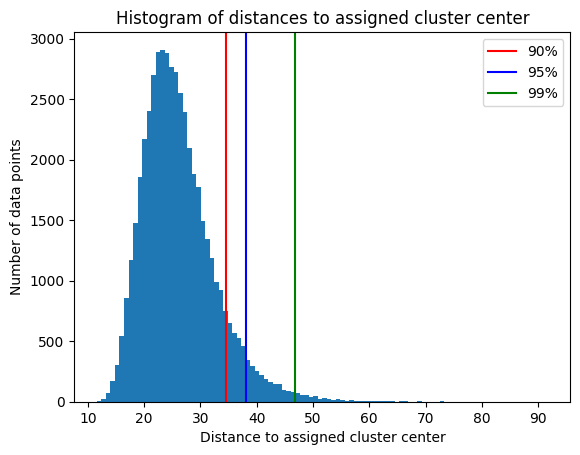

In [16]:
# show histogram and horizontal line where X% of the data is
plt.hist(distances_filtered, bins=100)
plt.axvline(np.percentile(distances_filtered, 90), color='red', label='90%')
plt.axvline(np.percentile(distances_filtered, 95), color='blue', label='95%')
plt.axvline(np.percentile(distances_filtered, 99), color='green', label='99%')
plt.xlabel('Distance to assigned cluster center')
plt.ylabel('Number of data points')
plt.title('Histogram of distances to assigned cluster center')
plt.legend()
plt.show()

In [17]:
# for each class, compute the data point closest to the cluster center
distances_argmin = []
for i in range(10):
    distances_argmin.append(np.argmin(distances[:, i], axis=0))

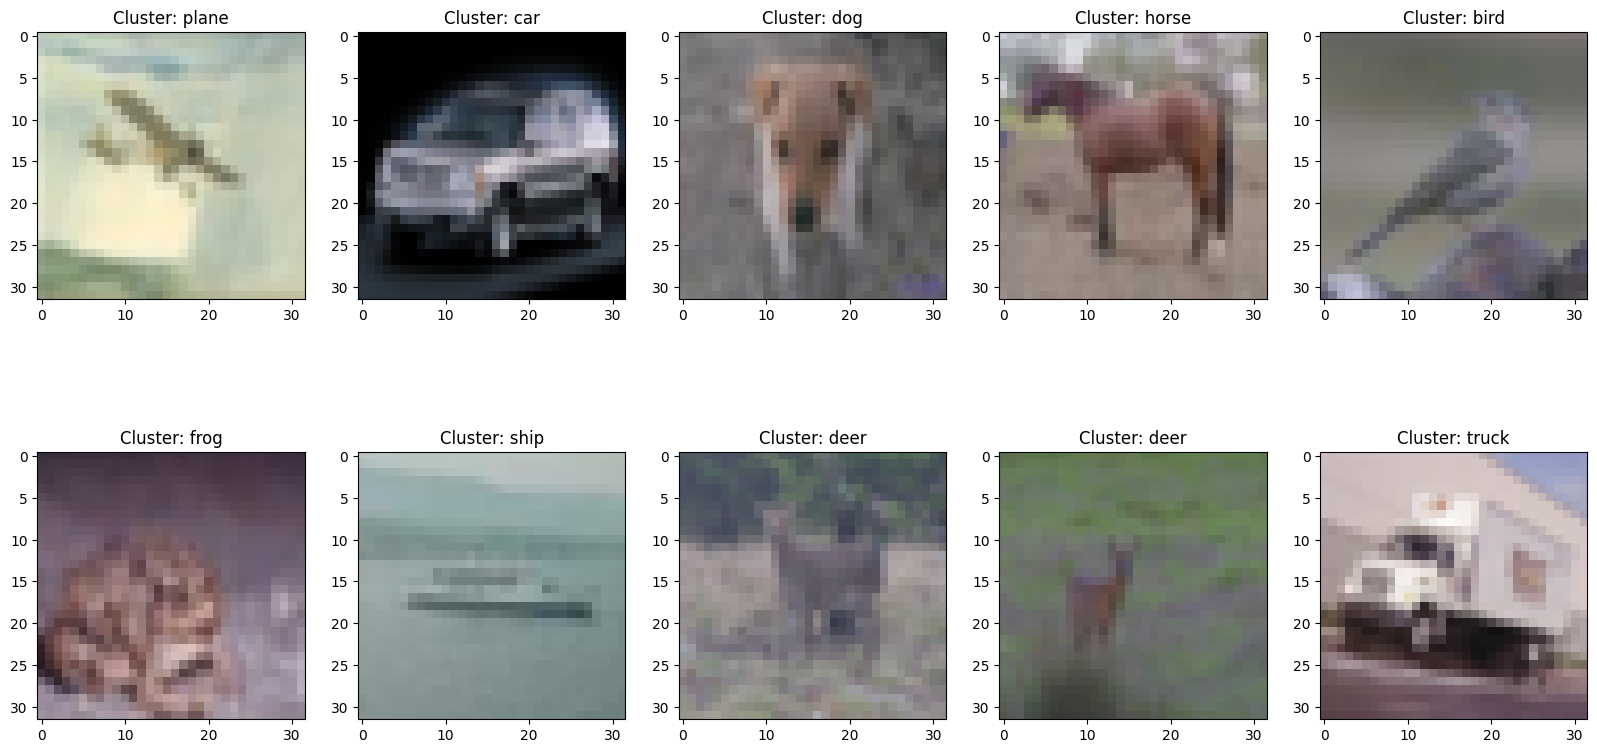

In [18]:
# plot images closest to cluster centers
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    ax[i//5, i%5].imshow(trainset[distances_argmin[i]][0].squeeze().numpy().transpose(1,2,0))
    # ax[i//5, i%5].set_title(f'Cluster: {i}')
    ax[i//5, i%5].set_title(f'Cluster: {classes[trainset[distances_argmin[i]][1]]}')
plt.show()

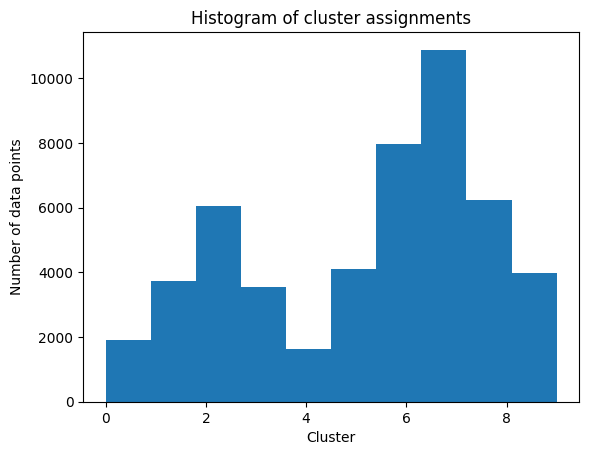

In [19]:
# histogram of y_pred
plt.hist(y_pred_array, bins=10, )
plt.xlabel('Cluster')
plt.ylabel('Number of data points')
plt.title('Histogram of cluster assignments')
plt.show()

In [20]:
images = []
y_true_list = []

for i in range(len(trainset)):
    images.append(trainset[i][0])
    y_true_list.append(trainset[i][1])

y_true_array = np.array(y_true_list)

plane 632
bird 564
ship 238
frog 134
cat 93
car 85
deer 52
truck 42
horse 30
dog 29


car 3537
horse 150
frog 26
plane 9
dog 5
bird 4
deer 2
cat 2


dog 3114
cat 1490
horse 578
bird 481
frog 165
deer 131
plane 29
truck 22
ship 17
car 13


horse 2784
deer 581
dog 88
bird 34
plane 19
cat 16
truck 5
ship 4
frog 1
car 1


bird 498
plane 464
ship 333
frog 87
car 81
cat 50
deer 40
horse 39
truck 22
dog 22


frog 3105
cat 379
deer 245
bird 227
dog 64
car 29
ship 21
horse 17
truck 12
plane 8


ship 3728
plane 2909
truck 421
car 389
bird 255
deer 131
cat 47
frog 30
horse 28
dog 25


cat 2552
bird 1374
deer 1277
dog 1268
horse 1100
truck 773
frog 750
plane 714
ship 554
car 517


deer 2542
bird 1558
frog 719
horse 413
dog 381
cat 361
plane 162
ship 42
car 38
truck 23


truck 3530
car 310
plane 54
ship 37
horse 11
cat 10
dog 7
bird 5
frog 4
deer 1




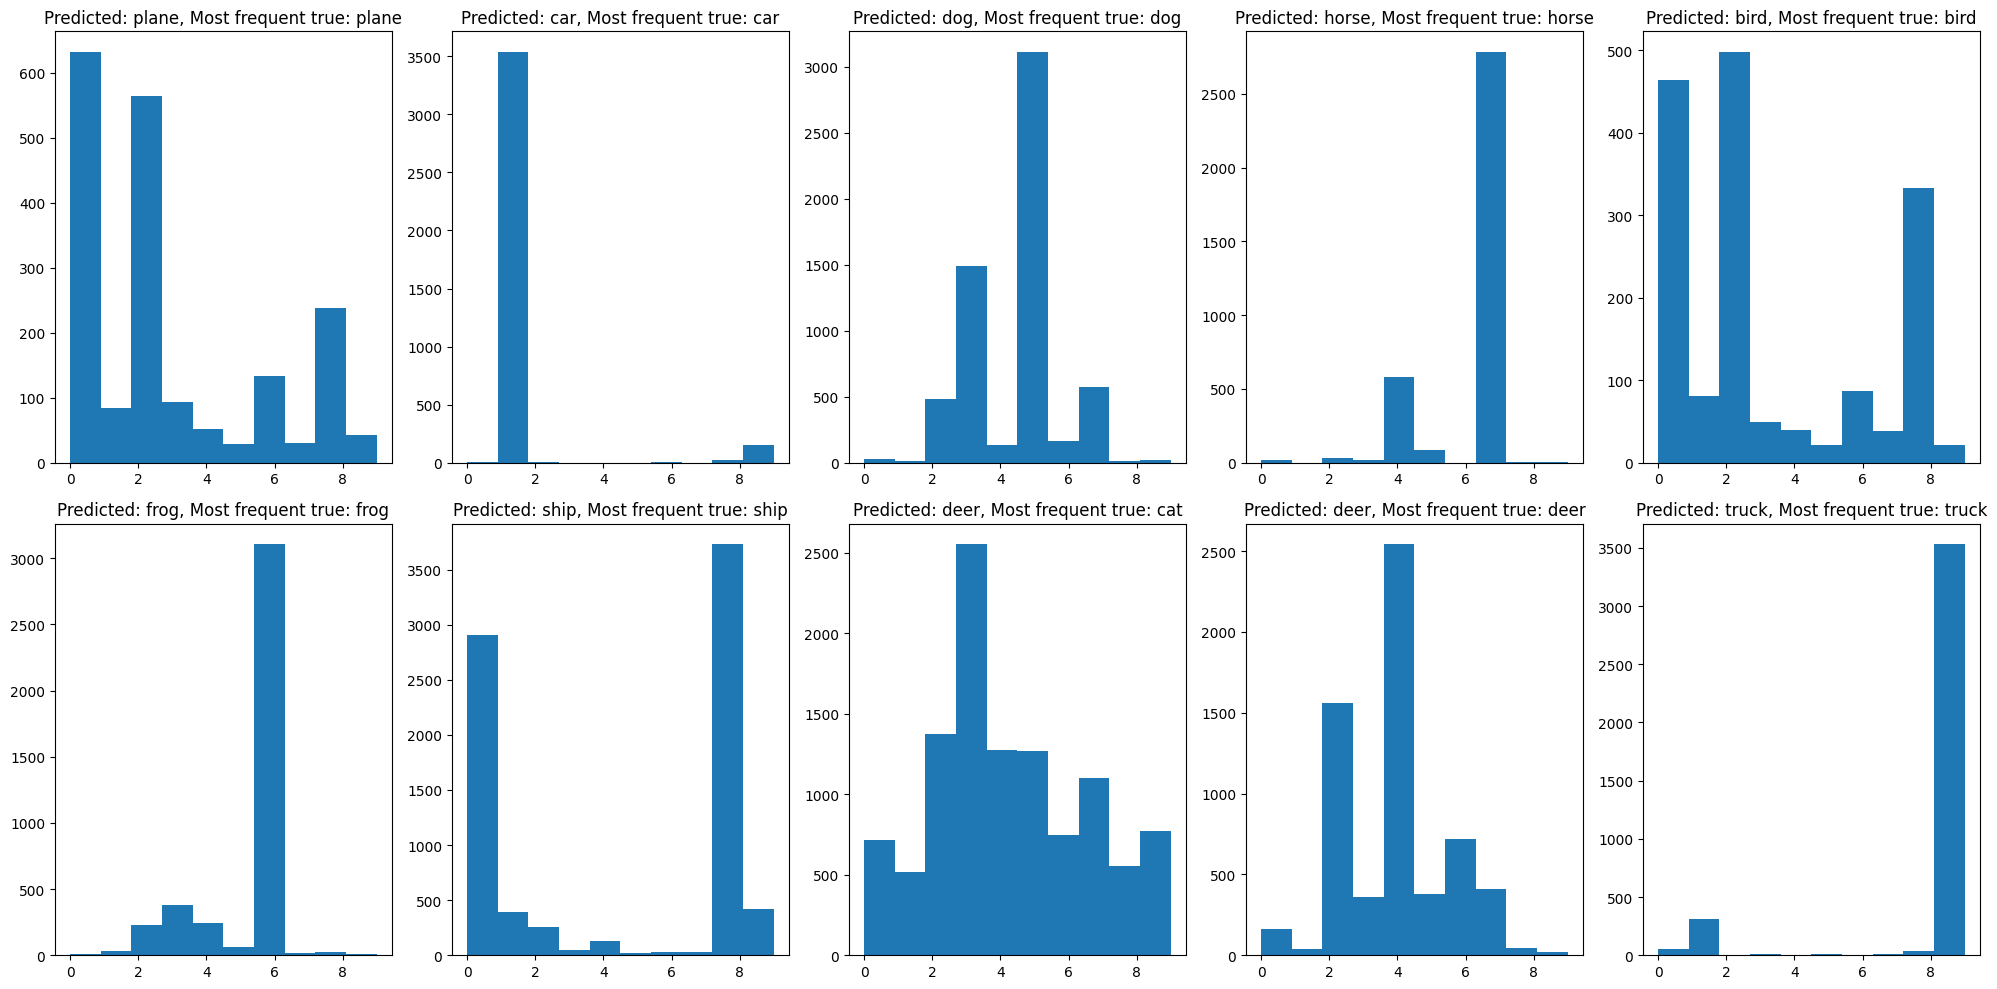

In [21]:
# histogram for each class distribution of true labels
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    indices = np.where(y_pred_array == i)[0]
    ax[i//5, i%5].hist(y_true_array[indices], bins=10)
    
    # get the most frequent label for each cluster
    a = classes[np.unique(y_true_array[indices], return_counts=True)[1].argmax()]
    
    ax[i//5, i%5].set_title(f'Predicted: {classes[trainset[distances_argmin[i]][1]]}, Most frequent true: {a}')

    # print the labels by decreasing frequency
    for j in np.unique(y_true_array[indices], return_counts=True)[1].argsort()[::-1]:
        print(classes[j], np.unique(y_true_array[indices], return_counts=True)[1][j])
    print('\n')

plt.tight_layout()
plt.show()

In [22]:
from sklearn.manifold import TSNE

# plot tsne of outputs
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(outputs_list_array)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.008s...


[t-SNE] Computed neighbors for 50000 samples in 12.990s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sample 13000 / 50000
[t-SNE] Computed conditional probabilities for sample 14000 / 5000

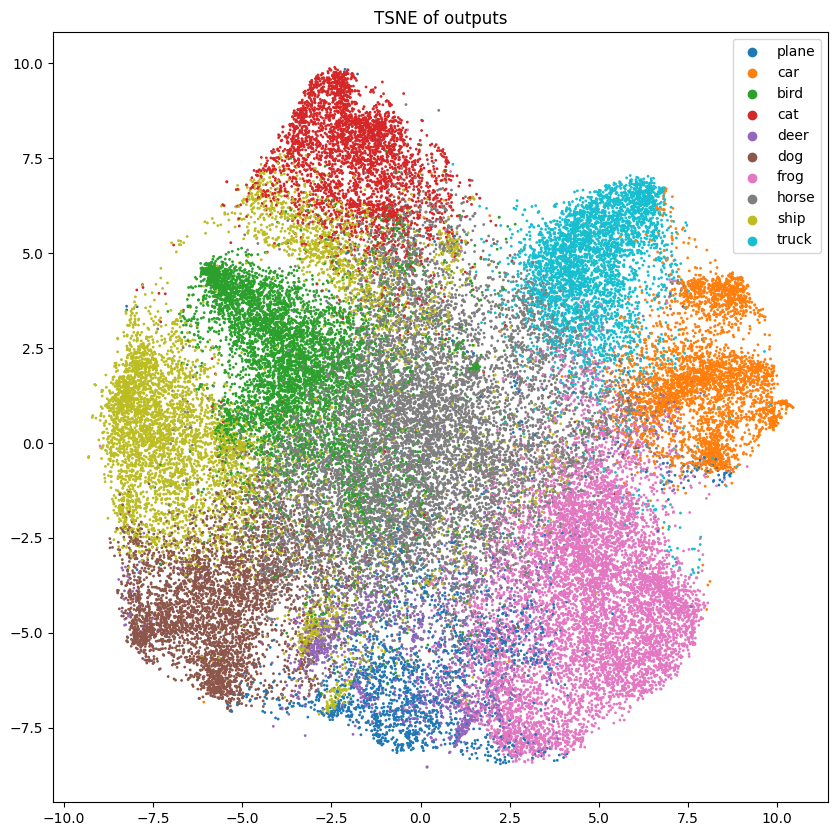

In [23]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_pred_array, cmap='tab10', s=1)
plt.title('TSNE of outputs')
# show label of colors
for i in range(10):
    plt.scatter([], [], c=f'C{i}', label=classes[i])
plt.legend()
plt.show()

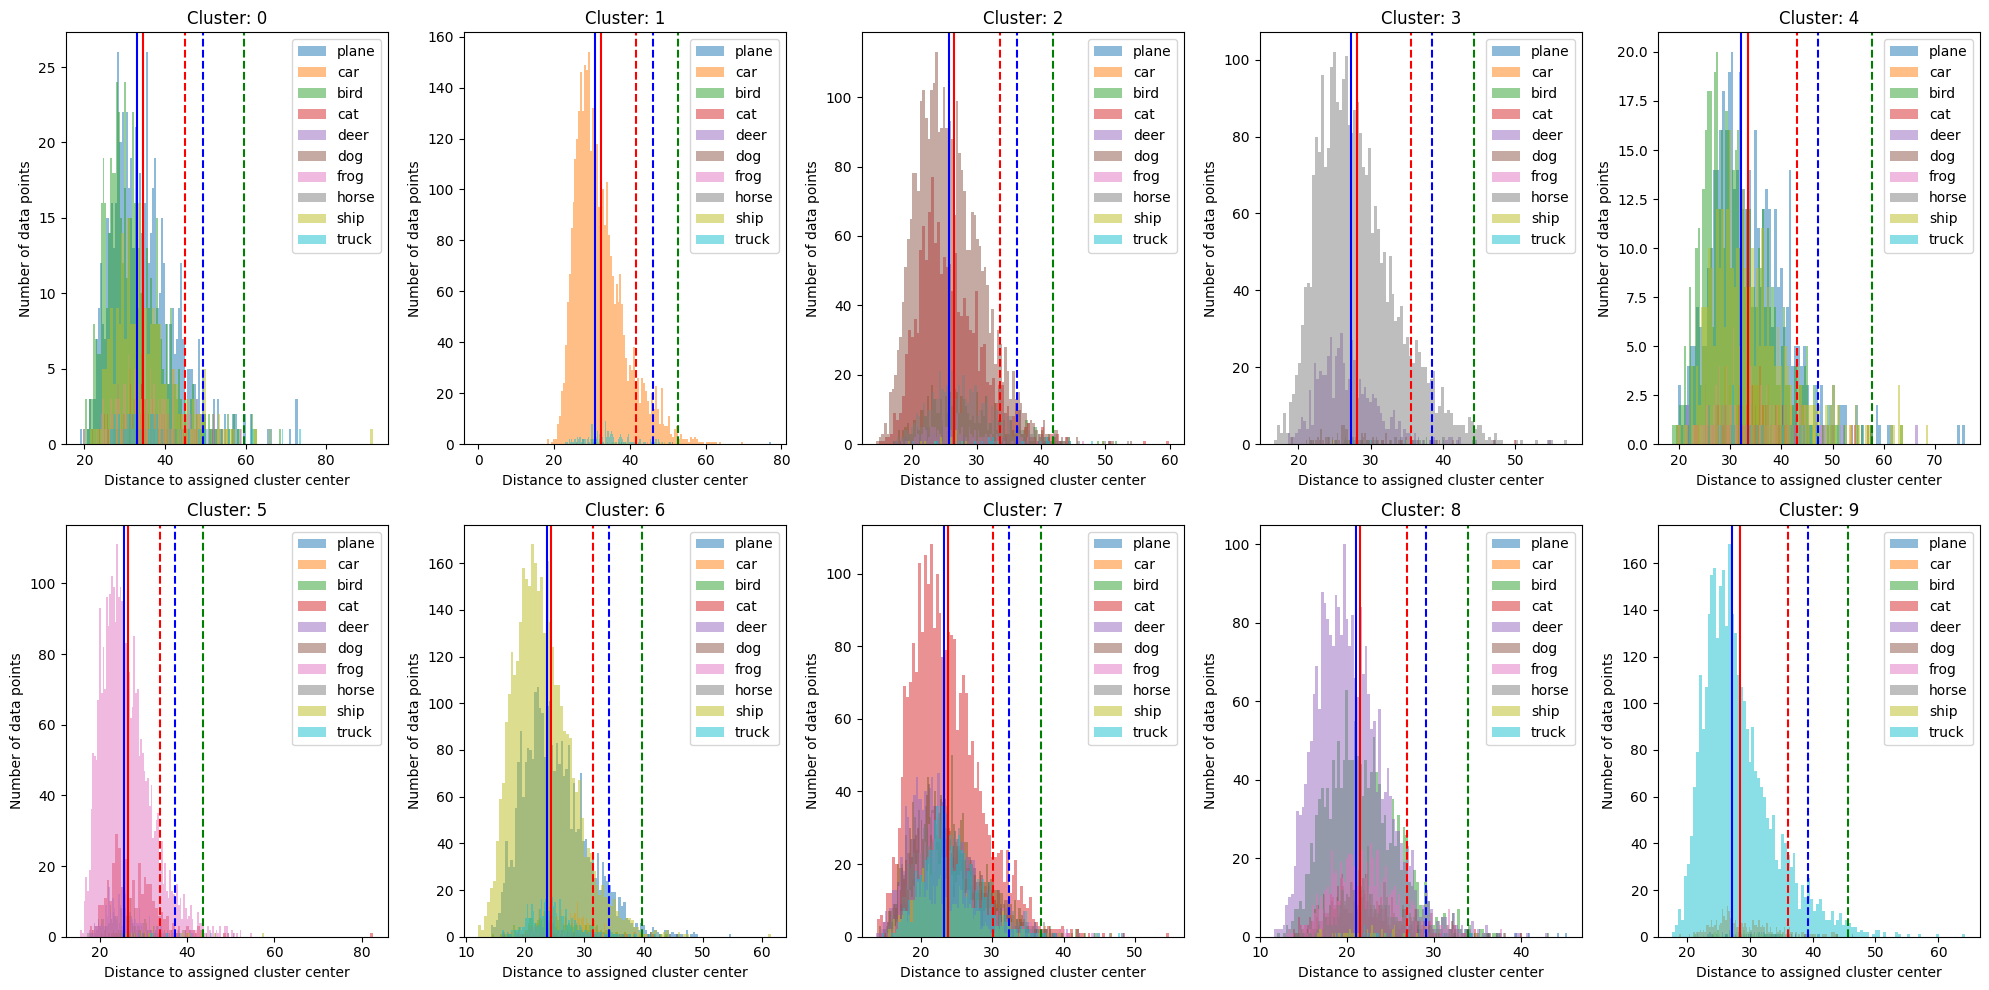

In [24]:
# for each cluster, plo sthe distribution of distances within the cluster
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for cluster_i in range(10):
    distances_cluster_i = distances[np.where(y_pred_array == cluster_i)[0], cluster_i]
    labels = y_true_array[np.where(y_pred_array == cluster_i)[0]]

    # plot histogram with color according to true label, show the legend
    for i in range(10):
        ax[cluster_i//5, cluster_i%5].hist(distances_cluster_i[np.where(labels == i)[0]], bins=100, color=f'C{i}', alpha=0.5)
    ax[cluster_i//5, cluster_i%5].legend(classes)


    # ax[cluster_i//5, cluster_i%5].hist(distances_cluster_i, bins=100)
    ax[cluster_i//5, cluster_i%5].set_title(f'Cluster: {cluster_i}')

    # mean and median vertical
    ax[cluster_i//5, cluster_i%5].axvline(np.mean(distances_cluster_i), color='red', label='mean')
    ax[cluster_i//5, cluster_i%5].axvline(np.median(distances_cluster_i), color='blue', label='median')

    # show X% of the data
    ax[cluster_i//5, cluster_i%5].axvline(np.percentile(distances_cluster_i, 90), color='red', linestyle='--', label='90%')
    ax[cluster_i//5, cluster_i%5].axvline(np.percentile(distances_cluster_i, 95), color='blue', linestyle='--', label='95%')
    ax[cluster_i//5, cluster_i%5].axvline(np.percentile(distances_cluster_i, 99), color='green', linestyle='--', label='99%')

    ax[cluster_i//5, cluster_i%5].set_xlabel('Distance to assigned cluster center')
    ax[cluster_i//5, cluster_i%5].set_ylabel('Number of data points')
    # ax[cluster_i//5, cluster_i%5].legend()

plt.tight_layout()
plt.show()


In [25]:
budgets = {
    0: 730,
    1: 100, # done
    2: 730,
    3: 200, # done
    4: 730,
    5: 200, # done
    6: 730,
    7: 750,
    8: 730,
    9: 100 # done
}

indices = []
for cluster_i in range(10):
    distances_cluster_i = distances[np.where(y_pred_array == cluster_i)[0], cluster_i]

    # pick top budget i images furthest away from cluster center
    indices.append(np.argsort(distances_cluster_i)[::-1][:budgets[cluster_i]])

# stack indices
indices = np.hstack(indices)

In [26]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 300
SUBSET_PROP = 0.01
CIFAR10_class_distribution = 0.10

# pick images from trainset and create new dataset and data loader
trainset_sup = torch.utils.data.Subset(trainset, indices)

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    RandAugmentMC(n=2, m=10),
    transforms.Normalize(mean, std)
])

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [27]:
print("Start training")

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    running_accuracy = 0
    moving_avg_pred_labeled = 0
    moving_avg_pred_unlabeled = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # normalize labeled and unlabeled inputs
        labeled_inputs_norm, unlabeled_inputs_norm = normalize(labeled_inputs, mean, std), normalize(unlabeled_inputs, mean, std)

        # labeled_outputs_norm = model(labeled_inputs_norm)
        unlabeled_outputs_norm = model(unlabeled_inputs_norm)

        # Compute moving average of labeled and unlabeled predictions
        moving_avg_pred_unlabeled = (i * moving_avg_pred_unlabeled + unlabeled_outputs_norm.shape[0]) / (i + 1)

        # ratio
        ratio = CIFAR10_class_distribution / moving_avg_pred_unlabeled

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # prediction on weak augmented unlabeled data
        qb = model(weak_unlabeled_inputs)
        qb = torch.softmax(qb, dim=1)
        qb_norm = qb * ratio

        # normalize
        qb_tilde = qb_norm / torch.sum(qb_norm, dim=1, keepdim=True)

        # compute mask
        max_qb_tilde, qb_tilde_hat = torch.max(qb_tilde, dim=1)
        idx = max_qb_tilde > TAU

        # pseudo labels
        pseudo_labels = qb_tilde_hat[idx]

        # mask strong augmented unlabeled data
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        running_accuracy += 100 * correct / total

        

        # update progress bar
        pbar.set_postfix({
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "avg confidence": torch.mean(max_qb_tilde).item(),
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })

    # update loss
    train_losses.append(running_loss / (i + 1))
    train_accuracies.append(running_accuracy / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)
        test_accuracies.append(test_accuracy)

Start training


Epoch     0:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 24.54%


Epoch     1:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 34.06%


Epoch     2:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 38.65%


Epoch     3:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 41.22%


Epoch     4:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 41.28%


Epoch     5:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 46.15%


Epoch     6:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 48.29%


Epoch     7:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 50.25%


Epoch     8:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 53.14%


Epoch     9:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 52.05%


Epoch    10:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 53.51%


Epoch    11:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 55.03%


Epoch    12:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 52.24%


Epoch    13:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.8%


Epoch    14:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.14%


Epoch    15:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 50.77%


Epoch    16:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.45%


Epoch    17:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.4%


Epoch    18:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.94%


Epoch    19:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.26%


Epoch    20:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 60.5%


Epoch    21:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 60.65%


Epoch    22:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.98%


Epoch    23:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 61.84%


Epoch    24:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 61.35%


Epoch    25:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.27%


Epoch    26:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.43%


Epoch    27:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.41%


Epoch    28:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.42%


Epoch    29:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.18%


Epoch    30:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.08%


Epoch    31:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.49%


Epoch    32:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.85%


Epoch    33:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.18%


Epoch    34:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.83%


Epoch    35:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.26%


Epoch    36:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.71%


Epoch    37:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.92%


Epoch    38:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.95%


Epoch    39:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.16%


Epoch    40:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.88%


Epoch    41:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.12%


Epoch    42:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.67%


Epoch    43:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.33%


Epoch    44:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.35%


Epoch    45:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.2%


Epoch    46:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.19%


Epoch    47:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.24%


Epoch    48:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.91%


Epoch    49:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.5%


Epoch    50:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.95%


Epoch    51:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.84%


Epoch    52:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.57%


Epoch    53:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.36%


Epoch    54:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.14%


Epoch    55:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.99%


Epoch    56:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.46%


Epoch    57:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.01%


Epoch    58:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.35%


Epoch    59:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.63%


Epoch    60:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.7%


Epoch    61:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.08%


Epoch    62:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.15%


Epoch    63:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.93%


Epoch    64:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.09%


Epoch    65:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.8%


Epoch    66:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.41%


Epoch    67:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.57%


Epoch    68:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.41%


Epoch    69:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.31%


Epoch    70:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.62%


Epoch    71:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.8%


Epoch    72:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.14%


Epoch    73:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.7%


Epoch    74:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.44%


Epoch    75:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.65%


Epoch    76:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.06%


Epoch    77:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.03%


Epoch    78:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.04%


Epoch    79:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.26%


Epoch    80:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.85%


Epoch    81:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.63%


Epoch    82:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.54%


Epoch    83:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.84%


Epoch    84:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.17%


Epoch    85:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.56%


Epoch    86:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.07%


Epoch    87:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.34%


Epoch    88:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.1%


Epoch    89:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.06%


Epoch    90:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.67%


Epoch    91:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.29%


Epoch    92:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.65%


Epoch    93:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.01%


Epoch    94:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.5%


Epoch    95:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.72%


Epoch    96:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.35%


Epoch    97:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.79%


Epoch    98:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.28%


Epoch    99:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.81%


Epoch   100:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.19%


Epoch   101:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.44%


Epoch   102:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.87%


Epoch   103:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.49%


Epoch   104:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.64%


Epoch   105:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.61%


Epoch   106:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.93%


Epoch   107:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.87%


Epoch   108:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.4%


Epoch   109:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.81%


Epoch   110:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.61%


Epoch   111:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.0%


Epoch   112:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.96%


Epoch   113:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.93%


Epoch   114:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.72%


Epoch   115:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.95%


Epoch   116:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.46%


Epoch   117:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.89%


Epoch   118:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.68%


Epoch   119:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.6%


Epoch   120:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.17%


Epoch   121:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.03%


Epoch   122:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.66%


Epoch   123:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.17%


Epoch   124:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.58%


Epoch   125:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.08%


Epoch   126:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.27%


Epoch   127:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.01%


Epoch   128:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.45%


Epoch   129:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.1%


Epoch   130:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.92%


Epoch   131:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.92%


Epoch   132:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.89%


Epoch   133:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.61%


Epoch   134:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.96%


Epoch   135:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.92%


Epoch   136:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.73%


Epoch   137:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.18%


Epoch   138:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.2%


Epoch   139:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.92%


Epoch   140:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.46%


Epoch   141:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.28%


Epoch   142:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.57%


Epoch   143:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.5%


Epoch   144:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.95%


Epoch   145:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.35%


Epoch   146:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.91%


Epoch   147:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.23%


Epoch   148:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.28%


Epoch   149:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.66%


Epoch   150:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.8%


Epoch   151:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.55%


Epoch   152:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.24%


Epoch   153:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.39%


Epoch   154:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.18%


Epoch   155:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.75%


Epoch   156:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.02%


Epoch   157:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.93%


Epoch   158:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.14%


Epoch   159:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.1%


Epoch   160:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.55%


Epoch   161:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.98%


Epoch   162:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.79%


Epoch   163:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.68%


Epoch   164:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.8%


Epoch   165:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.87%


Epoch   166:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.17%


Epoch   167:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.64%


Epoch   168:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.56%


Epoch   169:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.62%


Epoch   170:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.96%


Epoch   171:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.2%


Epoch   172:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.66%


Epoch   173:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.37%


Epoch   174:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.36%


Epoch   175:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.09%


Epoch   176:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.0%


Epoch   177:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.36%


Epoch   178:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.39%


Epoch   179:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.0%


Epoch   180:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.49%


Epoch   181:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.03%


Epoch   182:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.67%


Epoch   183:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.14%


Epoch   184:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.56%


Epoch   185:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.3%


Epoch   186:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.28%


Epoch   187:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.24%


Epoch   188:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.46%


Epoch   189:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.53%


Epoch   190:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.41%


Epoch   191:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.49%


Epoch   192:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.19%


Epoch   193:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.13%


Epoch   194:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.64%


Epoch   195:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.15%


Epoch   196:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.74%


Epoch   197:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.63%


Epoch   198:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.52%


Epoch   199:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.04%


Epoch   200:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.62%


Epoch   201:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.67%


Epoch   202:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.78%


Epoch   203:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.01%


Epoch   204:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.01%


Epoch   205:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.63%


Epoch   206:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.12%


Epoch   207:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.4%


Epoch   208:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.12%


Epoch   209:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.39%


Epoch   210:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.59%


Epoch   211:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.08%


Epoch   212:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.17%


Epoch   213:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.69%


Epoch   214:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.18%


Epoch   215:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.59%


Epoch   216:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.32%


Epoch   217:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.06%


Epoch   218:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.12%


Epoch   219:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.47%


Epoch   220:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.42%


Epoch   221:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.17%


Epoch   222:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.83%


Epoch   223:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.66%


Epoch   224:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.32%


Epoch   225:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.67%


Epoch   226:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.97%


Epoch   227:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.4%


Epoch   228:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.7%


Epoch   229:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.56%


Epoch   230:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.81%


Epoch   231:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.6%


Epoch   232:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.55%


Epoch   233:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.86%


Epoch   234:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.42%


Epoch   235:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.41%


Epoch   236:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.28%


Epoch   237:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.62%


Epoch   238:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.72%


Epoch   239:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.49%


Epoch   240:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.45%


Epoch   241:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.58%


Epoch   242:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.78%


Epoch   243:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.97%


Epoch   244:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.67%


Epoch   245:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.25%


Epoch   246:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.77%


Epoch   247:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.71%


Epoch   248:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.02%


Epoch   249:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.56%


Epoch   250:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.79%


Epoch   251:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.94%


Epoch   252:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.98%


Epoch   253:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.78%


Epoch   254:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.66%


Epoch   255:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.87%


Epoch   256:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.03%


Epoch   257:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.79%


Epoch   258:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.72%


Epoch   259:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.02%


Epoch   260:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.92%


Epoch   261:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.05%


Epoch   262:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.94%


Epoch   263:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.99%


Epoch   264:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.94%


Epoch   265:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.08%


Epoch   266:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.92%


Epoch   267:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.19%


Epoch   268:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.26%


Epoch   269:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.29%


Epoch   270:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.99%


Epoch   271:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.14%


Epoch   272:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.24%


Epoch   273:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.11%


Epoch   274:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.11%


Epoch   275:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.09%


Epoch   276:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.12%


Epoch   277:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.22%


Epoch   278:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.28%


Epoch   279:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.19%


Epoch   280:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.12%


Epoch   281:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.94%


Epoch   282:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.2%


Epoch   283:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.17%


Epoch   284:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.16%


Epoch   285:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.02%


Epoch   286:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.03%


Epoch   287:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.03%


Epoch   288:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.05%


Epoch   289:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.04%


Epoch   290:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.04%


Epoch   291:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.03%


Epoch   292:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.07%


Epoch   293:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.07%


Epoch   294:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.15%


Epoch   295:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.14%


Epoch   296:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.1%


Epoch   297:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.07%


Epoch   298:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.07%


Epoch   299:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.08%


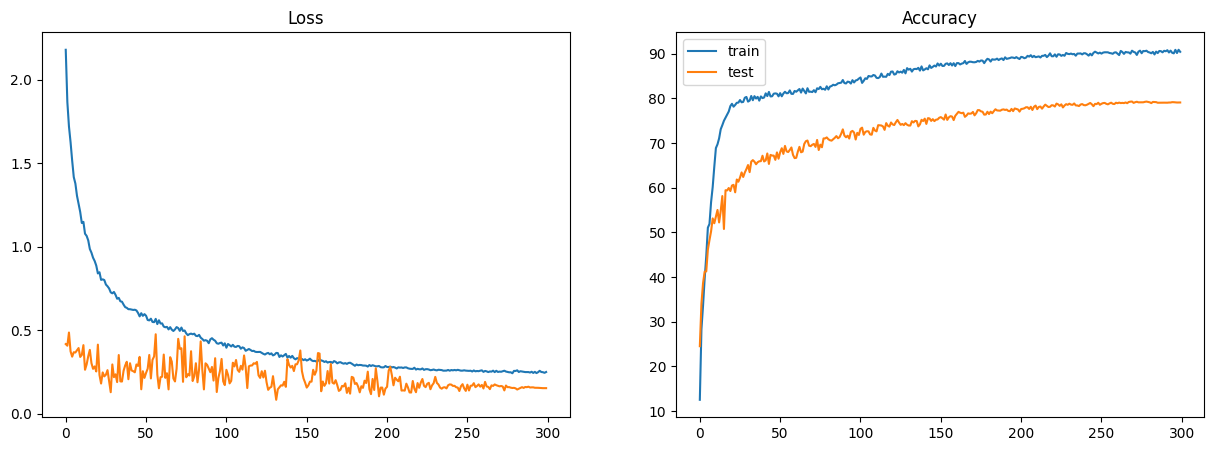

In [28]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/unsup_10_losses_accuracies_DC.png")

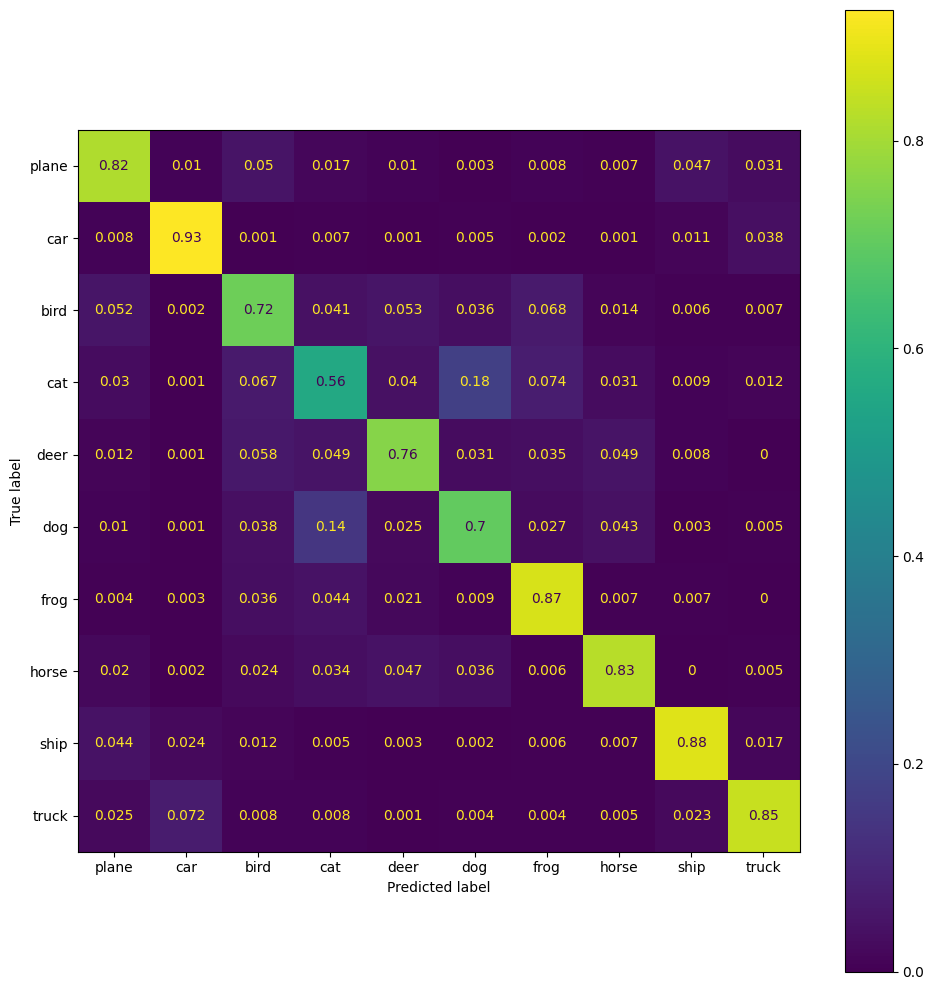

In [29]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/unsup_10_confusion_matrix_DC.png")

Test Accuracy: 79.08%


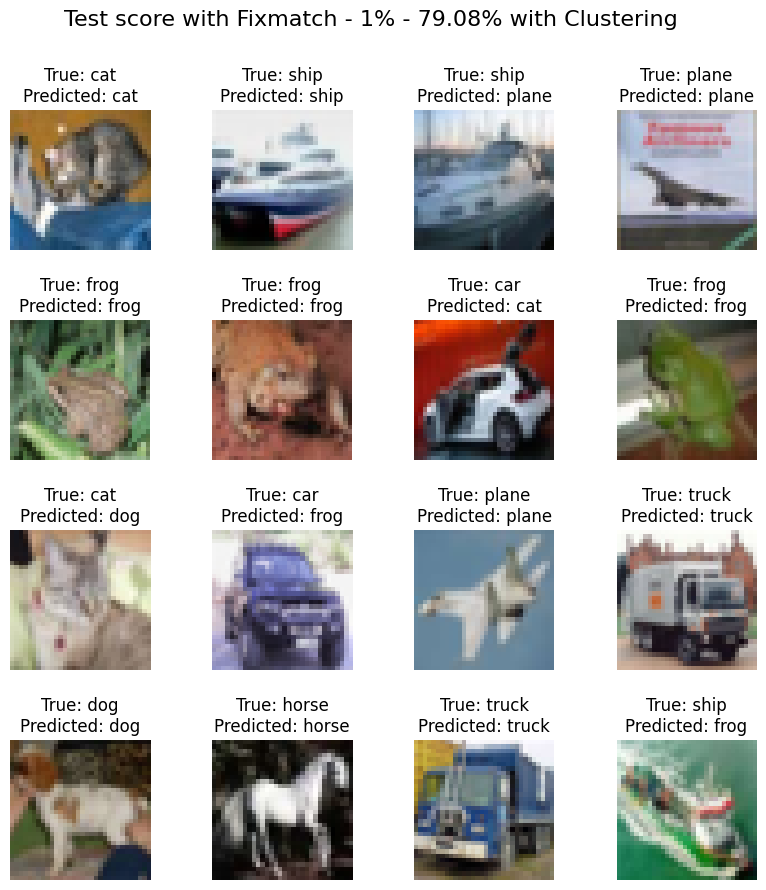

In [30]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_10_fixmatch_DC.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}% with Clustering")
fig1.savefig(f"./figures/test_score_10_fixmatch_DC.png")

### III.2 Fixmatch on 5% train data

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.05

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [ ]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, max_qb.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)


In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_5_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")

### III.3 Fixmatch on 1% train data

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.01

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [ ]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, max_qb.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)


In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_1_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")